Completed in  3  minutes and  59 seconds.


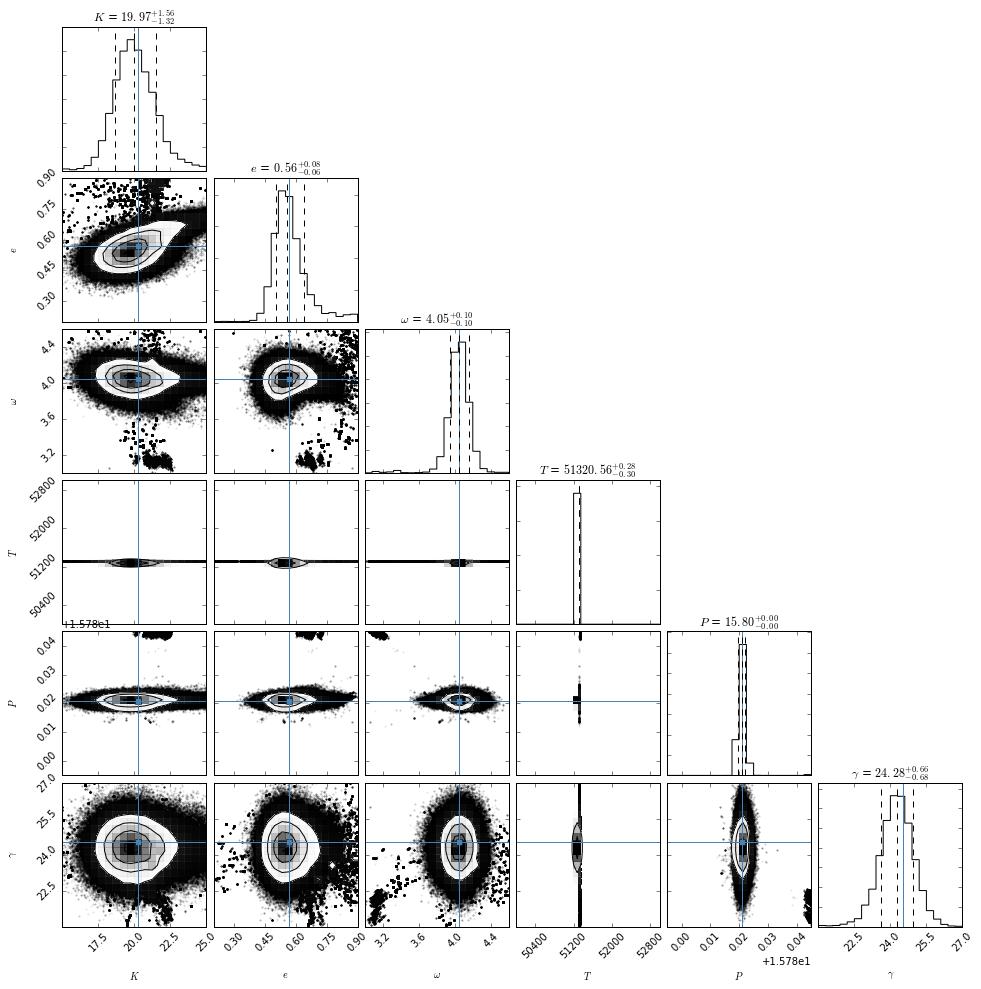

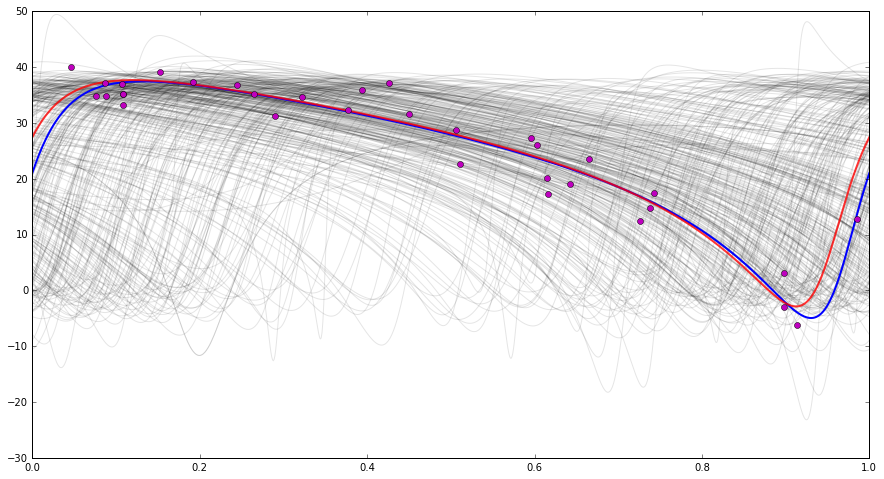

In [8]:
#this is pretty messy, I intend to go through and cleanup / annotate soon
#This code is built from the example found here: http://dan.iel.fm/emcee/current/user/line/#results
import time
t0 = time.time()
import numpy as np
import emcee
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import functions as f
import corner
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV
residuals   = f.residuals

for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break

mass_ratio = 0.898896068135
Period = 15.8045

#this function is a slighty tweaked version of the plotter function, designed to play nicely with
#scipy's curvefit function. Used for an initial estimate of the parameters, from the primary data
def alteredRV(x, K, e, w, T, P, y): #function generates RV values plot from given parameters
    M = (2*np.pi/P)*(x-T) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True: #iteratively refines estimate of E1 from initial estimate
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    p = ((K)*(np.cos(nu+w) + (e*np.cos(w)))+y)
    return p

initial_guess, cov = curve_fit(alteredRV, JDp, np.asarray(RVp),
                            bounds=([0, 0, 0, JD[0], 15, 10], [200, 0.9, 2*np.pi, JD[-1], 16.6, 35]))

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

def constraints(parameters):
    K, e, w, T, P, y = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5]
    if  0 < K < 200 and 0 < e < 0.9 and 0 < w < 2*np.pi and JD[0] < T < JD[-1] and 15 < P < 16.6 and 10 < y < 35:
        return 0
    return -np.inf

def probability(initial_guess, mass_ratio, RVp, RVs):
    con = constraints(initial_guess)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)

#running the MCMC process
ndim, nwalkers = 6, 200
pos = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
#idea for improvement: initialize walkers with gaussian balls of varying sizes, depending on parameter
sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(mass_ratio, RVp, RVs), threads = 4)
sampler.run_mcmc(pos, 10000)


#create the corner plot
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"],
                    extents=[[15, 25], [0.2, 0.9], [3, 4.6], [50000, 53000], [15.775, 15.825], [21, 27]],
                    truths = [20.28, 0.568, 4.047, 47433.507, 15.800905, 24.52],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
#fig.savefig("triangle.png")

x = np.linspace(0, 15.800905, num=1000)
plt.figure(figsize=(15,8))
for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=300)]:
    parameters = K, e, w, T, P, y
    primary = RV(x, mass_ratio, parameters)[0]
    plt.plot(x/parameters[4], RV(x, mass_ratio, parameters)[0], color="k", alpha=0.1)

plt.plot(x/parameters[4], RV(x, mass_ratio, initial_guess)[0], color="b", lw=2) #initial guess curve

primary = RV(x, mass_ratio, [20.28, 0.568, 4.047, 47433.507, 15.800905, 24.52])[0] 
plt.plot(x/15.800905, primary, color="r", lw=2, alpha=0.8) #Czekala et al. result

plt.plot(phases(15.800905, 0, JDp), RVp, 'mo') #data phased to initial guess period
plt.xlim(0,1)

#I'm curious why the semiamplitude doesn't seem to be changing much during the MCMC process

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')